In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 53.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 96.9 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 37.2 MB/s eta 0:00:00


# **GPT2 con fine tuning**

In [2]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
MODEL_DIR_PATH = '/workspace/4geeks-lyric-generator/models/'
LYRICS_DIR_PATH = '/workspace/4geeks-lyric-generator/data/processed/'
GPT_2_TYPE = 'gpt2-medium'
#gpt2-medium
#gpt2-large
#gpt2-xl
MODEL_FILE_NAME = 'model_'+ GPT_2_TYPE +'.pt'
LYRICS_CSV_FILE = 'lyrics_small.csv'

In [5]:
df_lyrics = pd.read_csv(LYRICS_DIR_PATH + LYRICS_CSV_FILE)

In [6]:
df_lyrics = df_lyrics.dropna()

In [7]:
df_lyrics = df_lyrics.drop_duplicates()

In [8]:
df_lyrics = df_lyrics.convert_dtypes()

In [9]:
#Elimino letras muy largas
df_lyrics = df_lyrics[df_lyrics['Lyrics'].apply(lambda x: len(x.split(' ')) < 350)]

In [10]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 0 to 1100
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Artist  1101 non-null   string
 1   Title   1101 non-null   string
 2   Lyrics  1101 non-null   string
dtypes: string(3)
memory usage: 34.4 KB


In [11]:
df_lyrics.describe()

,Artist,Title,Lyrics
count,1101,1101,1101
unique,10,1094,1097
top,Pearl Jam,Better Man,"Well I've got a secret, I cannot say.\r\nBlame..."
freq,147,2,2


In [12]:
print("Artistas en el dataset:\n", df_lyrics['Artist'].value_counts()) 

Artistas en el dataset:
 Pearl Jam                  147
Foo Fighters               145
Soundgarden                144
Oasis                      141
Metallica                  137
Queens Of The Stone Age    130
Fastball                    92
Linkin Park                 79
Audioslave                  52
Nirvana                     34
Name: Artist, dtype: Int64


In [13]:
print("Tamaño del dataset:", df_lyrics.shape)

Tamaño del dataset: (1101, 3)


In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
df_lyrics["Nro_de_caracteres"] = df_lyrics["Lyrics"].apply(len)
df_lyrics["Nro_de_palabras"]= df_lyrics.apply(lambda row: nltk.word_tokenize(row["Lyrics"]), axis=1).apply(len)
df_lyrics["Nro_de_lineas"] = df_lyrics["Lyrics"].str.split('\n').apply(len)
df_lyrics.describe()

,Nro_de_caracteres,Nro_de_palabras,Nro_de_lineas
count,1101.000000,1101.000000,1101.000000
mean,1090.222525,265.897366,35.598547
std,408.159194,101.373178,13.159668
min,12.000000,4.000000,2.000000
25%,807.000000,196.000000,27.000000
50%,1070.000000,259.000000,34.000000
75%,1355.000000,328.000000,43.000000
max,2440.000000,604.000000,99.000000


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

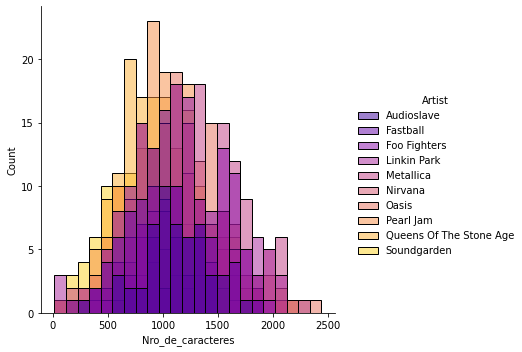

In [17]:
sns.displot(df_lyrics, x="Nro_de_caracteres", hue="Artist", palette="plasma")

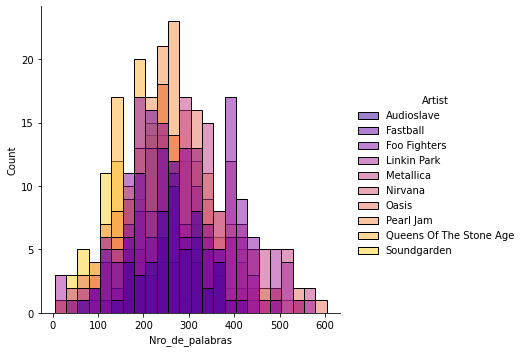

In [18]:
sns.displot(df_lyrics, x="Nro_de_palabras", hue="Artist", palette="plasma")

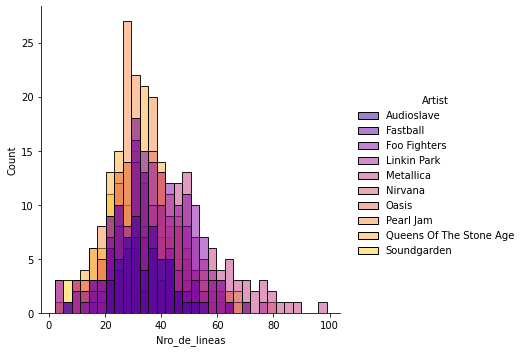

In [19]:
sns.displot(df_lyrics, x="Nro_de_lineas", hue="Artist", palette="plasma")

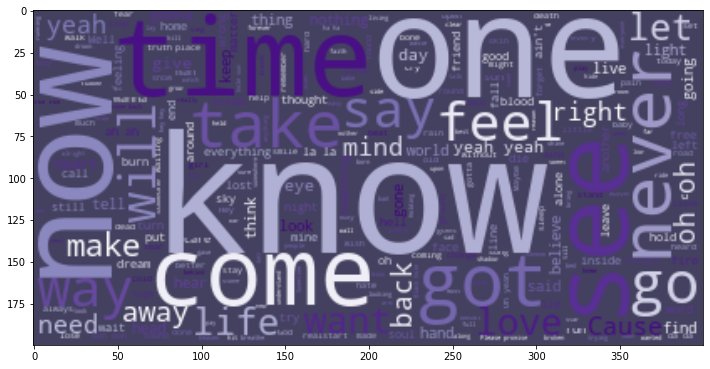

In [20]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(df_lyrics["Lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [21]:
df_lyrics = df_lyrics.drop(columns=['Artist','Title','Nro_de_caracteres','Nro_de_palabras','Nro_de_lineas'])

In [24]:
#Selecciono aleatoriamente un 5% del dataset con set de prueba
test_set = df_lyrics.sample(n = int(len(df_lyrics)*0.05))
#El resto es el conjunto de entrenamiento
df_lyrics = df_lyrics.loc[~df_lyrics.index.isin(test_set.index)]

#Reseteo índices
test_set = test_set.reset_index()
df_lyrics = df_lyrics.reset_index()

In [25]:
print("Tamaño del dataset de prueba:", test_set.shape)
print("Tamaño del dataset de entrenamiento:", df_lyrics.shape)

Tamaño del dataset de prueba: (49, 3)
Tamaño del dataset de entrenamiento: (942, 3)


In [26]:
#Para el set de prueba, quito las últimas 20 palabras de la letra y las agrego en otra columna 'True_end_lyrics'
test_set['True_end_lyrics'] = test_set['Lyrics'].str.split().str[-20:].apply(' '.join)
test_set['Lyrics'] = test_set['Lyrics'].str.split().str[:-20].apply(' '.join)

In [27]:
test_set.sample(5)

,level_0,index,Lyrics,True_end_lyrics
40,657,723,"Restless soul, enjoy your youth. Like Muhammad...","you. Oh, this is not for you, yeah, you. This ..."
10,331,368,"So close, no matter how far. Couldn't be much ...",no matter how far. Couldn't be much more from ...
2,570,631,Wait 'til everybody's gone. And only I can see...,see. What it means to be. Sittin' here in sile...
22,126,141,From the moment I arise. Feel good from mornin...,the day. Till the end of the day. Till the end...
23,668,734,But you don't know where from she was thrown. ...,yeah. Hey yeah. I'm a lightning bolt. She's a ...


In [28]:
test_set = test_set.convert_dtypes()
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   level_0          49 non-null     Int64 
 1   index            49 non-null     Int64 
 2   Lyrics           49 non-null     string
 3   True_end_lyrics  49 non-null     string
dtypes: Int64(2), string(2)
memory usage: 1.8 KB


In [55]:
df_lyrics.to_csv(LYRICS_DIR_PATH + 'lyrics_test.csv',index=False)

In [29]:
df_lyrics = df_lyrics.convert_dtypes()
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   level_0  942 non-null    Int64 
 1   index    942 non-null    Int64 
 2   Lyrics   942 non-null    string
dtypes: Int64(2), string(1)
memory usage: 24.0 KB


In [56]:
df_lyrics.to_csv(LYRICS_DIR_PATH + 'lyrics_train.csv',index=False)

# **Preparo el dataset**

In [30]:
class SongLyrics(Dataset):
    
    def __init__(self, control_code, truncate=False, gpt2_type=GPT_2_TYPE, max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.lyrics = []

        for row in df_lyrics['Lyrics']:
          self.lyrics.append(torch.tensor(
                self.tokenizer.encode(f"<|{control_code}|>{row[:max_length]}<|endoftext|>")
            ))
                
        if truncate:
            self.lyrics = self.lyrics[:20000]
        self.lyrics_count = len(self.lyrics)
        
    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return self.lyrics[item]

In [31]:
dataset = SongLyrics(df_lyrics['Lyrics'], truncate=True, gpt2_type=GPT_2_TYPE)

In [32]:
tokenizer = GPT2Tokenizer.from_pretrained(GPT_2_TYPE)
model = GPT2LMHeadModel.from_pretrained(GPT_2_TYPE)

In [33]:
#Accumulated batch size (since GPT2 is so big)
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [34]:
def train(
    dataset, model, tokenizer,
    batch_size=16, epochs=20, lr=2e-5,
    max_seq_len=400, warmup_steps=200,
    gpt2_type=GPT_2_TYPE, output_dir=".", output_prefix="wreckgar",
    test_mode=False,save_model_on_epoch=False,
):

    acc_steps = 100
    device=torch.device("cuda")
    model = model.cuda()
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
    )

    train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    loss=0
    accumulating_batch_count = 0
    input_tensor = None

    for epoch in range(epochs):

        print(f"Training epoch {epoch}/{epochs}")
        print(loss)
        for idx, entry in tqdm(enumerate(train_dataloader)):
            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None
        if save_model_on_epoch:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
            )
    return model

# **Entrenamiento**

In [35]:
#Train the model on the specific data we have
model = train(dataset, model, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Training epoch 0/20
0


942it [03:39,  4.30it/s]


Training epoch 1/20
tensor(3.2650, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:39,  4.29it/s]


Training epoch 2/20
tensor(2.1481, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:39,  4.29it/s]


Training epoch 3/20
tensor(1.5333, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:40,  4.28it/s]


Training epoch 4/20
tensor(0.8066, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:40,  4.28it/s]


Training epoch 5/20
tensor(1.1576, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:39,  4.30it/s]


Training epoch 6/20
tensor(1.2184, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:38,  4.31it/s]


Training epoch 7/20
tensor(0.9673, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:40,  4.28it/s]


Training epoch 8/20
tensor(1.0850, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:39,  4.30it/s]


Training epoch 9/20
tensor(1.1361, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:40,  4.28it/s]


Training epoch 10/20
tensor(0.8566, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:39,  4.30it/s]


Training epoch 11/20
tensor(0.4819, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:39,  4.29it/s]


Training epoch 12/20
tensor(1.3552, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:38,  4.31it/s]


Training epoch 13/20
tensor(0.7795, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:40,  4.27it/s]


Training epoch 14/20
tensor(1.3577, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:38,  4.31it/s]


Training epoch 15/20
tensor(0.9374, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:38,  4.32it/s]


Training epoch 16/20
tensor(0.8194, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:38,  4.30it/s]


Training epoch 17/20
tensor(0.6982, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:38,  4.32it/s]


Training epoch 18/20
tensor(1.0676, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:40,  4.27it/s]


Training epoch 19/20
tensor(0.4798, device='cuda:0', grad_fn=<NllLossBackward0>)


942it [03:38,  4.31it/s]


In [36]:
#Save the model to a pkl or something so it can be reused later on
torch.save(model, MODEL_DIR_PATH + MODEL_FILE_NAME)

De acá para abajo cuento con el modelo ya armado

In [ ]:
#Load the model to use it
model = torch.load(MODEL_DIR_PATH + MODEL_FILE_NAME)

In [37]:
import transformers
import torch

In [38]:
def generate(
    model,
    tokenizer,
    prompt,
    entry_count=10,
    entry_length=30, #maximum number of words
    top_p=0.8,
    temperature=1.,
):

    model.eval()

    generated_num = 0
    generated_list = []

    filter_value = -float("Inf")

    with torch.no_grad():

        for entry_idx in trange(entry_count):

            entry_finished = False

            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

            for i in range(entry_length):
                outputs = model(generated, labels=generated)
                loss, logits = outputs[:2]
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value

                next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token), dim=1)

                if next_token in tokenizer.encode("<|endoftext|>"):
                    entry_finished = True

                if entry_finished:

                    generated_num = generated_num + 1

                    output_list = list(generated.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)
                    generated_list.append(output_text)
                    break
            
            if not entry_finished:
              output_list = list(generated.squeeze().numpy())
              output_text = f"{tokenizer.decode(output_list)}<|endoftext|>" 
              generated_list.append(output_text)
                
    return generated_list

In [39]:
#Función para crear múltiples oraciones
def text_generation(test_data):
  generated_lyrics = []
  for i in range(len(test_data)):
    x = generate(model.to('cpu'), tokenizer, test_data['Lyrics'][i], entry_count=1)
    generated_lyrics.append(x)
  return generated_lyrics

In [40]:
generated_lyrics = text_generation(test_set)

100%|██████████| 1/1 [01:47<00:00, 107.90s/it]


In [42]:
#Loop to keep only generated text and add it as a new column in the dataframe
my_generations=[]

for i in range(len(generated_lyrics)):
  a = test_set['Lyrics'][i].split()[-30:] #Get the matching string we want (30 words)
  b = ' '.join(a)
  c = ' '.join(generated_lyrics[i]) #Get all that comes after the matching string
  my_generations.append(c.split(b)[-1])

test_set['Generated_lyrics'] = my_generations

In [43]:
#Finish the sentences when there is a point, remove after that
final=[]

for i in range(len(test_set)):
  to_remove = test_set['Generated_lyrics'][i].split('.')[-1]
  generated_lyric_without_endoftext_suffix = test_set['Generated_lyrics'][i].replace('<|endoftext|>','') 
  final.append(generated_lyric_without_endoftext_suffix.replace(to_remove,''))

test_set['Generated_lyrics'] = final

In [44]:
test_set.to_csv(LYRICS_DIR_PATH + 'generated_lyrics_fineTuned_model_'+ GPT_2_TYPE + '.csv',index=False)

In [78]:
test_set = pd.read_csv(LYRICS_DIR_PATH + 'generated_lyrics_fineTuned_model_'+ GPT_2_TYPE + '.csv')

In [79]:
test_set = test_set.fillna('')
test_set['Lyrics'] = test_set['Lyrics'].astype("string")
test_set['True_end_lyrics'] = test_set['True_end_lyrics'].astype("string")
test_set['Generated_lyrics'] = test_set['Generated_lyrics'].astype("string")
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   level_0           49 non-null     int64 
 1   index             49 non-null     int64 
 2   Lyrics            49 non-null     string
 3   True_end_lyrics   49 non-null     string
 4   Generated_lyrics  49 non-null     string
dtypes: int64(2), string(3)
memory usage: 2.0 KB


Analizo performance

In [45]:
#Using BLEU score to compare the real sentences with the generated ones
import statistics
from nltk.translate.bleu_score import sentence_bleu

scores=[]

for i in range(len(test_set)):
  reference = test_set['True_end_lyrics'][i]
  candidate = test_set['Generated_lyrics'][i]
  scores.append(sentence_bleu(reference, candidate))

statistics.mean(scores)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

1.2251002744637378e-231

In [57]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.8 MB/s 
     |████████████████████████████████| 1.3 MB 42.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=f819fa6eb8610d4d4099a3ee698c9c2d58c95ffc9011a42a7797d0a832c4e516
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [58]:
from sentence_transformers import SentenceTransformer, util

In [59]:
sentence_transformer_model = SentenceTransformer('stsb-roberta-large')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [80]:
cos_scores=[]

for i in range(len(test_set)):
  reference = test_set['True_end_lyrics'][i]
  candidate = test_set['Generated_lyrics'][i]
  print("Reference: ", reference)
  print("Candidate: ", candidate)
  #Calculo los embeddings de los segmentos de letra real y generada
  reference_embedding = sentence_transformer_model.encode(reference, convert_to_tensor=True)
  candidate_embedding = sentence_transformer_model.encode(candidate, convert_to_tensor=True)
  cosine_scores = util.pytorch_cos_sim(reference_embedding, candidate_embedding)
  normalized_cosine_score = (cosine_scores.item()/2)+0.5
  cos_scores.append(normalized_cosine_score)
  print("Similarity score: ", normalized_cosine_score)
  print("------------------------")

print("Mean Cosine Similarity score: ")
print(statistics.mean(cos_scores))

Reference:  resignations. This is a call to all. This is a call to all my past resignations. It's been too long.
Candidate:   resignations. This is a call to all. This is a call to all my past resignations. This is a call to all my past resign
Similarity score:  0.9646199345588684
------------------------
Reference:  bucket. The river runs red. Two tears in a bucket. Always fear for the undead. Always fear what I said.
Candidate:   wound that was never meant to end. (song ends)
Similarity score:  0.562335480004549
------------------------
Reference:  see. What it means to be. Sittin' here in silence on my own. Sittin' here in silence on my own.
Candidate:   see.

And only I can see.

Yeah, I got no soul to speak of.

And only I can see.
Similarity score:  0.7682144641876221
------------------------
Reference:  be enough to reach the truth that lies. Across this new divide. Across this new divide. Across this new divide.
Candidate:   be enough to reach the truth that lies.
Similarity sc

# **GPT2 sin fine tuning**

In [46]:
import transformers
import torch

In [47]:
tokenizer_without_finetuning = transformers.GPT2Tokenizer.from_pretrained(GPT_2_TYPE)
model_without_finetuning = transformers.GPT2LMHeadModel.from_pretrained(GPT_2_TYPE)

In [49]:
## Making a function that will generate text for us ##
def gen_text(prompt_text, tokenizer, model, n_seqs=1, max_length=374):
  # n_seqs is the number of sequences to generate
  # max_length is the maximum length of the sequence
  encoded_prompt = tokenizer.encode(prompt_text, add_special_tokens=False, return_tensors="pt")
  # We are encoding the text using the gpt tokenizer. The return tensors are of type "pt"
  # since we are using PyTorch, not tensorflow
  output_sequences = model.generate(
      input_ids=encoded_prompt,
      max_length=max_length+len(encoded_prompt), # The model has to generate something, 
      # so we add the length of the original sequence to max_length
      temperature=1.0,
      top_k=0,
      top_p=0.8,
      repetition_penalty=1.2, # To ensure that we dont get repeated phrases
      do_sample=True,
      num_return_sequences=n_seqs
  ) # We feed the encoded input into the model.
  ## Getting the output ##
  if len(output_sequences.shape) > 2:
    output_sequences.squeeze_() # the _ indicates that the operation will be done in-place
  generated_sequences = []
  for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
    generated_sequence = generated_sequence.tolist()
    text = tokenizer.decode(generated_sequence)
    total_sequence = (
        prompt_text + text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True, )) :]
    )
    generated_sequences.append(total_sequence)
  return generated_sequences

In [50]:
#Function to generate multiple sentences. Test data should be a dataframe
def text_generation(test_data):
  generated_lyrics = []
  for i in range(len(test_data)):
    x = gen_text(test_data['Lyrics'][i], tokenizer_without_finetuning, model_without_finetuning)
    generated_lyrics.append(x)
  return generated_lyrics

generated_lyrics = text_generation(test_set)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [51]:
#Loop to keep only generated text and add it as a new column in the dataframe
my_generations=[]

for i in range(len(generated_lyrics)):
  a = test_set['Lyrics'][i].split()[-30:] #Get the matching string we want (30 words)
  b = ' '.join(a)
  c = ' '.join(generated_lyrics[i]) #Get all that comes after the matching string
  my_generations.append(c.split(b)[-1])

test_set['Generated_lyrics'] = my_generations

In [52]:
#Finish the sentences when there is a point, remove after that
final=[]

for i in range(len(test_set)):
  to_remove = test_set['Generated_lyrics'][i].split('.')[-1]
  generated_lyric_without_endoftext_suffix = test_set['Generated_lyrics'][i].replace('<|endoftext|>','') 
  final.append(generated_lyric_without_endoftext_suffix.replace(to_remove,''))

test_set['Generated_lyrics'] = final
test_set.head()

,level_0,index,Lyrics,True_end_lyrics,Generated_lyrics
0,140,155,Visiting is pretty. Visiting is good. Seems th...,resignations. This is a call to all. This is a...,"resigned orders, crimes in $thousand seven hu..."
1,845,938,He walked in like he had a plan. Had the eyes ...,bucket. The river runs red. Two tears in a buc...,"step.""\n\nPowder nodded stiffly as Harry lick..."
2,570,631,Wait 'til everybody's gone. And only I can see...,see. What it means to be. Sittin' here in sile...,hear.'\n
3,281,306,I remembered black skies. The lightning all ar...,be enough to reach the truth that lies. Across...,"feel as if, beneath any walls of separation -..."
4,819,908,When I was young. We used to play the game of ...,"I , Come. There is no safe place. There is no ...",listen up piglet; This might not be very toug...


In [53]:
test_set.to_csv(LYRICS_DIR_PATH + 'generated_lyrics_model_'+ GPT_2_TYPE + '.csv',index=False)

In [81]:
test_set = pd.read_csv(LYRICS_DIR_PATH + 'generated_lyrics_model_'+ GPT_2_TYPE + '.csv')

In [82]:
test_set = test_set.fillna('')
test_set['Lyrics'] = test_set['Lyrics'].astype("string")
test_set['True_end_lyrics'] = test_set['True_end_lyrics'].astype("string")
test_set['Generated_lyrics'] = test_set['Generated_lyrics'].astype("string")
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   level_0           49 non-null     int64 
 1   index             49 non-null     int64 
 2   Lyrics            49 non-null     string
 3   True_end_lyrics   49 non-null     string
 4   Generated_lyrics  49 non-null     string
dtypes: int64(2), string(3)
memory usage: 2.0 KB


In [54]:
#Using BLEU score to compare the real sentences with the generated ones
import statistics
from nltk.translate.bleu_score import sentence_bleu

scores=[]

for i in range(len(test_set)):
  reference = test_set['True_end_lyrics'][i]
  candidate = test_set['Generated_lyrics'][i]
  scores.append(sentence_bleu(reference, candidate))

statistics.mean(scores)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

8.356112902384172e-232

In [83]:
cos_scores=[]

for i in range(len(test_set)):
  reference = test_set['True_end_lyrics'][i]
  candidate = test_set['Generated_lyrics'][i]
  print("Reference: ", reference)
  print("Candidate: ", candidate)
  #Calculo los embeddings de los segmentos de letra real y generada
  reference_embedding = sentence_transformer_model.encode(reference, convert_to_tensor=True)
  candidate_embedding = sentence_transformer_model.encode(candidate, convert_to_tensor=True)
  cosine_scores = util.pytorch_cos_sim(reference_embedding, candidate_embedding)
  normalized_cosine_score = (cosine_scores.item()/2)+0.5
  cos_scores.append(normalized_cosine_score)
  print("Similarity score: ", normalized_cosine_score)
  print("------------------------")

print("Mean Cosine Similarity score: ")
print(statistics.mean(cos_scores))

Reference:  resignations. This is a call to all. This is a call to all my past resignations. It's been too long.
Candidate:   resigned orders, crimes in $thousand seven hundred thirty million dollar cities? Gloopy fawns were added this year with their high profit margins.
Similarity score:  0.5736714825034142
------------------------
Reference:  bucket. The river runs red. Two tears in a bucket. Always fear for the undead. Always fear what I said.
Candidate:   step."

Powder nodded stiffly as Harry licked his lips again. "And you have these…ducks?" His voice quivered into different chimeras that didn't sound right to any but him; thanks for being dumb enough not really here anymore so many times when talking about pain rather than dying I suppose. He turned towards Clarke who was still standing there without blinking or turning away from them much longer waiting her turn next to Sirius if they felt too odd off their mounts then going back behind Albus with meek Regulus stuck at first g